# The Camp Fire was the deadliest and costliest natural disaster of 2018


![The Camp fire - a firefighter assessing burning building in Paradise, CA](https://static01.nyt.com/newsgraphics/2018/11/14/camp-fire-progression/assets/images/9971492an-2000_x2.jpg)
> Image source: 

You can get started learning about the fire from the following sources:
  * [Fire in Paradise](https://www.pbs.org/wgbh/frontline/documentary/fire-in-paradise/), a documentary from PBS
  * ["Hell on Earth"](https://www.nytimes.com/interactive/2018/11/18/us/california-camp-fire-paradise.html) and [What's next after the Camp fire destroyed Paradise](https://www.nytimes.com/interactive/2018/12/26/us/paradise-california-camp-fire.html), interactive reporting from the New York Times
  * [Incident report](https://www.fire.ca.gov/incidents/2018/11/8/camp-fire) from CalFire

In [7]:
# Import libraries

import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import keyring
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Create path to project directory
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'waldo-canyon')

# Create project directory
os.makedirs(project_dir, exist_ok=True)
project_dir

'/home/jovyan/earth-analytics/data/waldo-canyon'

In [9]:
# Define url for data
wc_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_2012/FeatureServer/0/query"
    "?where=incidentname%20%3D%20'WALDO%20CANYON'"
    "%20AND%20latest%20%3D%20'Y'"
    "&outFields=*&outSR=4326&f=json"
    )

wc_gdf

,OBJECTID,agency,comments,active,latest,complexname,mapmethod,complexfirecode,incidentname,uniquefireidentifier,...,perimeterdatetime,incomplex,fireyear,gisacres,inciwebid,pooresponsibleunit,state,shape__Area,shape__Length,geometry
0,4393,USFS,FIMT,N,Y,,Unknown,NaN,Waldo Canyon,2012-COPSF-000636,...,1341532800000,N,2012,18262.138052,2929,COPSF,CO,1.222984e+08,194277.180042,"MULTIPOLYGON (((-104.97945 38.97994, -104.9792..."


In [10]:
# Waldo, CO location
# From https://waterdata.usgs.gov/monitoring-location/07100750/#parameterCode=00065&period=P7D&showMedian=true
wc_lat = 38.8881111
wc_lon = -104.9356944

# Create a Folium map object
m = folium.Map(
    location=[wc_lat, wc_lon], 
    zoom_start=11,
    scrollWheelZoom=False
    )

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="ESRI World Imagery",
    overlay=False,
    control=True,
)
esri_world_imagery.add_to(m)

camp_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 2,
    "dashArray": "5, 5",
}

# Convert the GeoDataFrame to GeoJSON format
wc_geojson = wc_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
folium.GeoJson(
    wc_geojson,
    style_function=lambda feature: camp_style
    ).add_to(m)

# Add a marker for Paradise, CA
folium.Marker(location=[wc_lat, wc_lon], popup='Waldo Canyon, CO').add_to(m)

# Display the map as an HTML file or display it inline
m

### Data Description

The data used for this analysis is the NDVI (Normalized Difference Vegetation Index) derived from reflectance bands measured by the Moderate Resolution Imaging Spectroradiometer (MODIS) aboard the satellite Aqua. MODIS measures Near-InfraRed (NIR) radiation, as well as visible light wavelengths and calculates the normalized difference vegetation index (NDVI) through the formula: NDVI = (NIR - Red) / (NIR + Red). Healthy (green) vegetation reflects a greater proportion of NIR to (NIR + Red) wavelengths than unhealthy (yellow or red) vegeatation, therefore a higher NDVI value reflects healthier vegetation. NDVI data are collected over a 16 day period at a 250 meter resolution and the best pixel value (selecting for low cloud coverage, low view angle, and highest resultant NVDI value) is used for that interval.

### Citation: 

Didan, K. (2015). <i>MYD13Q1 MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V006</i> [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-09-25 from https://doi.org/10.5067/MODIS/MYD13Q1.006

In [11]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="wc-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2012, 2017],
    polygon=wc_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

INFO:root:Submitting task request...
INFO:root:Logging into AppEEARS API...


HTTPError: 401 Client Error: UNAUTHORIZED for url: https://appeears.earthdatacloud.nasa.gov/api/login

In [10]:
ndvi_path_list = (
    glob(os.path.join(ndvi_downloader.data_dir, '*', '*NDVI*.tif')))

ndvi_path_list

['/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2019137_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2018185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2017169_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2021185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2022169_aid000

In [23]:
doy_start = -19
doy_end = -12
scale_factor = 10000

# Create for loop for iterating over files

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 144, x: 205)>
 array([[[0.5017, 0.6231, 0.6237, ..., 0.7794, 0.8023, 0.8023],
         [0.5582, 0.5582, 0.6397, ..., 0.7343, 0.7343, 0.7642],
         [0.5804, 0.5733, 0.718 , ..., 0.8314, 0.7765, 0.7974],
         ...,
         [0.5749, 0.5678, 0.6132, ..., 0.7506, 0.7981, 0.7981],
         [0.6034, 0.6181, 0.6132, ..., 0.7981, 0.7981, 0.7981],
         [0.6156, 0.6156, 0.5998, ..., 0.7906, 0.8064, 0.8064]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -121.8 -121.8 -121.8 ... -121.4 -121.4 -121.4
   * y            (y) float64 39.9 39.89 39.89 39.89 ... 39.61 39.6 39.6 39.6
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2019-05-17,
 <xarray.DataArray 'NDVI' (date: 1, y: 144, x: 205)>
 array([[[0.4765, 0.5597, 0.5503, ..., 0.6885, 0.7655, 0.7655],
         [0.4696, 0.4696, 0.5508, ..., 0.76  , 0.76  , 0.7703],
         [0.4446, 0.4602, 0.5992, ..., 0.7718, 0.7842, 0.7842],
        

In [25]:
# Stack arrays
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 205, y: 144, date: 41)
Coordinates:
    band         int64 1
  * x            (x) float64 -121.8 -121.8 -121.8 ... -121.4 -121.4 -121.4
  * y            (y) float64 39.9 39.89 39.89 39.89 ... 39.61 39.6 39.6 39.6
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2017-05-17 2017-06-02 ... 2022-08-21
Data variables:
    NDVI         (date, y, x) float32 0.5136 0.6001 0.5736 ... 0.4264 0.4514

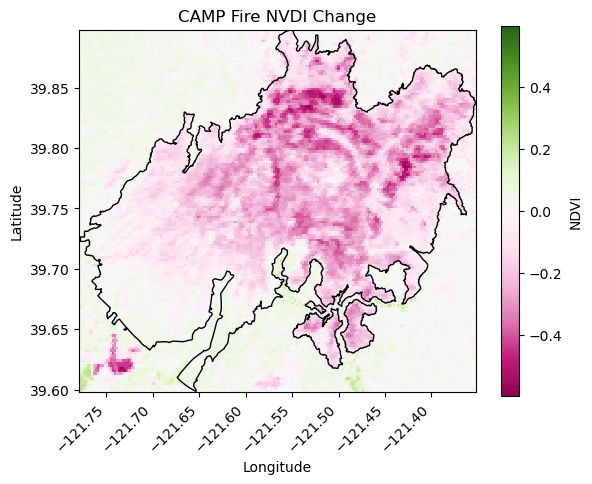

In [27]:
# Calculation of the change in NDVI pre and post fire
dndvi_da = (ndvi_ds
    .sel(date='2019')
    .mean('date')
    .NDVI 
- ndvi_ds
    .sel(date='2017')
    .mean('date')
    .NDVI
)

# Plot of the change in NDVI pre and post fire
dndvi_da.plot(cmap=plt.colormaps['PiYG'])
camp_gdf.plot(facecolor='none', ax=plt.gca())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CAMP Fire NVDI Change')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()


In [28]:
# Define the area outside surrounding the fire boundary
square_gdf = gpd.GeoDataFrame(geometry=camp_gdf.envelope)


# Get the area outside the fire boundary
out_gdf = square_gdf.overlay(camp_gdf, how="difference")
out_gdf

,geometry
0,"MULTIPOLYGON (((-121.77783 39.59859, -121.7778..."


In [30]:
# Clip NDVI to boundaries
ndvi_fire_ds = ndvi_ds.rio.clip(camp_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)


# Check coordinate reference frames for datasets
#  ndvi_ds.rio.crs, camp_gdf.crs

In [31]:
# Calculate average NDVI for each year and save as a dataframe
ndvi_fire_df = (ndvi_fire_ds
 .groupby(ndvi_fire_ds.date.dt.year)
 .mean(...).NDVI
 .to_dataframe()[['NDVI']]
)

ndvi_out_df = (ndvi_out_ds
 .groupby(ndvi_fire_ds.date.dt.year)
 .mean(...).NDVI
 .to_dataframe()[['NDVI']]
)

ndvi_fire_df, ndvi_out_df

(          NDVI
 year          
 2017  0.623880
 2018  0.626274
 2019  0.462839
 2020  0.503273
 2021  0.487732
 2022  0.524007,
           NDVI
 year          
 2017  0.616702
 2018  0.615244
 2019  0.625270
 2020  0.616613
 2021  0.494234
 2022  0.548292)

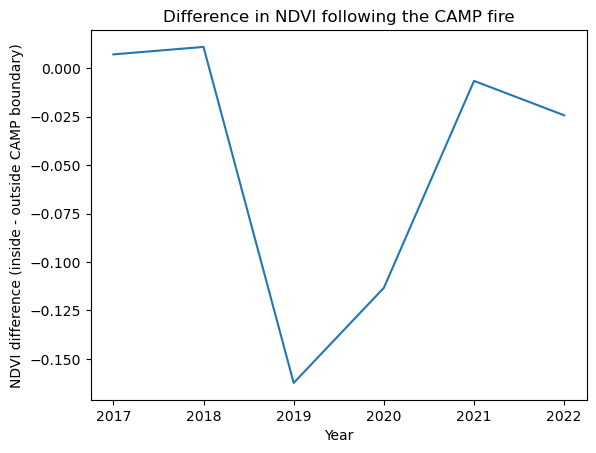

In [33]:
# Calculate and plot the difference in NDVI inside and outside the fire boundary
(ndvi_fire_df - ndvi_out_df).plot()
plt.xlabel('Year')
plt.ylabel('NDVI difference (inside - outside CAMP boundary)')
plt.title('Difference in NDVI following the CAMP fire')
plt.legend('', frameon=False)


### Vegetation nearly recovered within 2 years after the CAMP fire

Peak NDVI dropped by 0.15 inside the fire boundary compared to outside in the two years following the fire, and then recovered to pre-fire values. NDVI alone does not allow us to distinguish between types of vegetation. More information is needed to assess the full timescale of forestry recovery in the wake of the fire. 

## Your turn! Repeat this workflow in a different time and place for your portfolio.

It's not just water rights that affect NDVI! You could look at: 
  * Recovery after a national disaster, like a wildfire or hurricane
  * The effects of drought on crop health
  * Deforestation

You can even choose a different dataset, like Landsat, and/or a different spectral index. [Check out some other ways to enhance images and highlight different phenomena](https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices)